In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load the balanced dataset to create encoder
print("Loading dataset to create encoder...")
df = pd.read_csv('final_train_ready_scrubbed.csv')

# Create the encoder from the Label column
encoder = LabelEncoder()
encoder.fit(df['Label'])

print("Encoder created successfully!")
print(f"Label classes: {encoder.classes_}")

Loading dataset to create encoder...
Encoder created successfully!
Label classes: ['DoS' 'Fuzzy' 'Gear' 'Normal' 'RPM']


In [3]:
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import time

# 1. Load the scrubbed, balanced data
print("Loading dataset...")
df = pd.read_csv('final_train_ready_scrubbed.csv')

# 2. Split Features and Target
X = df.drop(columns=['Label_Encoded', 'Label'])
y = df['Label_Encoded']

# 3. Create a smaller subset for Tuning (e.g., 10% of data)
# This makes Grid Search finish in minutes instead of hours
_, X_tune, _, y_tune = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
print(f"Tuning on {len(X_tune)} samples...")

# 4. Define the Parameter Grid
# These are the "knobs" we will turn to find the best setting
param_grid = {
    'n_estimators': [50, 100],          # Number of trees (Paper used ~50, we test higher too)
    'learning_rate': [0.5, 1.0],        # How "aggressive" the learning is
    'estimator__max_depth': [1, 2, 3]   # Depth of the weak learners (Decision Trees)
}

# 5. Initialize the Base Model
# Note: In newer sklearn, 'base_estimator' is renamed to 'estimator'
base_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)

# 6. Setup Grid Search with 5-Fold CV (As per paper)
print("Starting Grid Search with 5-Fold CV...")
start_time = time.time()

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,               # 5-Fold Cross Validation
    scoring='accuracy', # We want to maximize Accuracy
    n_jobs=-1,          # Use all CPU cores
    verbose=1
)

grid_search.fit(X_tune, y_tune)

print(f"\nSearch completed in {time.time() - start_time:.2f} seconds.")
print(f"Best Accuracy: {grid_search.best_score_:.4f}")
print("Best Parameters:", grid_search.best_params_)

Loading dataset...
Tuning on 76845 samples...
Starting Grid Search with 5-Fold CV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Search completed in 38.49 seconds.
Best Accuracy: 1.0000
Best Parameters: {'estimator__max_depth': 3, 'learning_rate': 0.5, 'n_estimators': 100}


Loading full dataset for final training...

Using Best Parameters from GridSearch:
  n_estimators: 100
  learning_rate: 0.5
  max_depth: 3

Final Training Set Size: 614752 samples
Final Test Set Size: 153689 samples

Training FINAL AdaBoost model with best parameters...
Final model training completed!

Generating predictions...

FINAL MODEL ACCURACY: 100.00%

CLASSIFICATION REPORT
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     31217
       Fuzzy       1.00      1.00      1.00     31217
        Gear       1.00      1.00      1.00     31217
      Normal       1.00      1.00      1.00     28821
         RPM       1.00      1.00      1.00     31217

    accuracy                           1.00    153689
   macro avg       1.00      1.00      1.00    153689
weighted avg       1.00      1.00      1.00    153689


CONFUSION MATRIX (Numerical)
[[31217     0     0     0     0]
 [    0 31217     0     0     0]
 [    0     0 31217     0     0

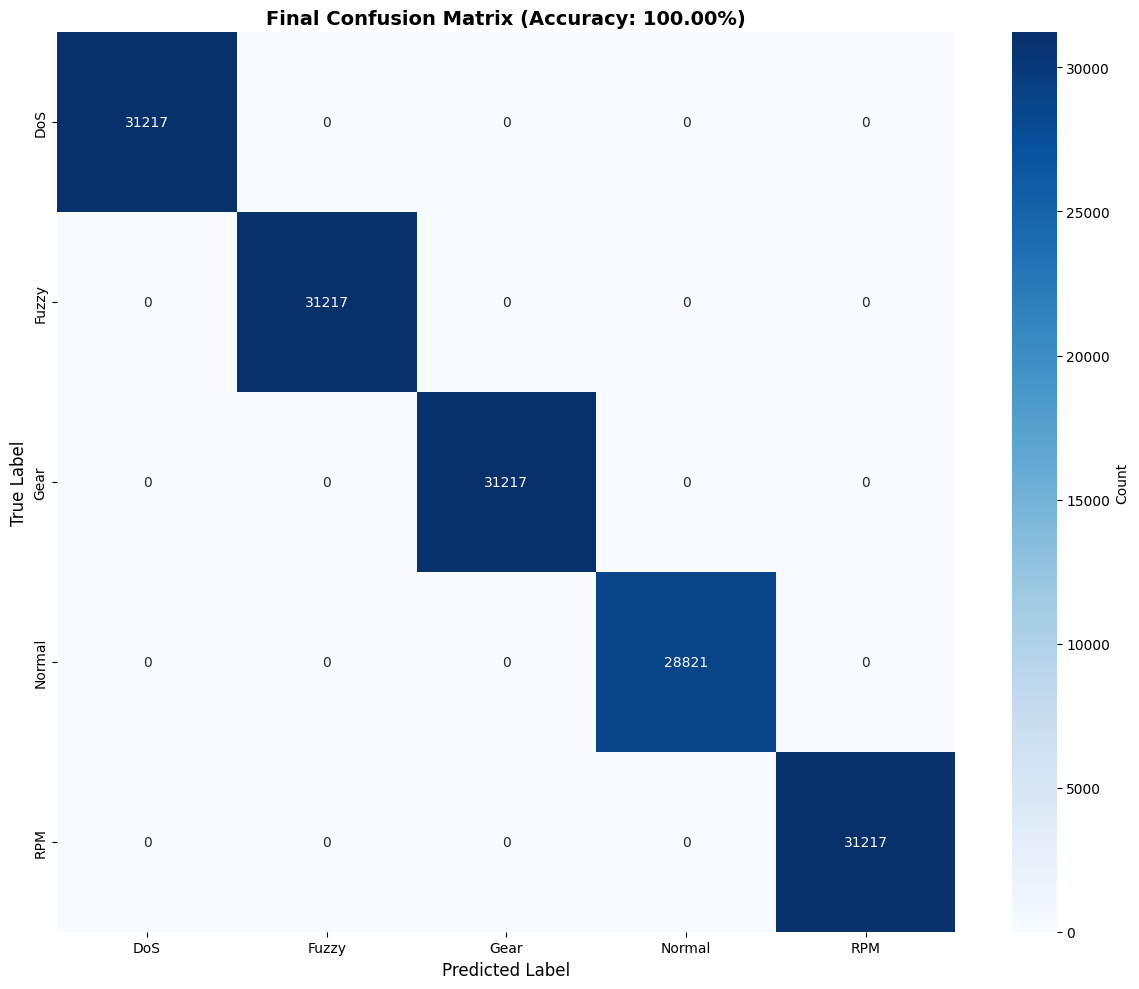


PER-CLASS ACCURACY
DoS             → 100.00%
Fuzzy           → 100.00%
Gear            → 100.00%
Normal          → 100.00%
RPM             → 100.00%


In [4]:
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load the full scrubbed dataset
print("Loading full dataset for final training...")
df = pd.read_csv('final_train_ready_scrubbed.csv')

# 2. Extract features and target
X = df.drop(columns=['Label_Encoded', 'Label'])
y = df['Label_Encoded']

# 3. Get the BEST parameters from Grid Search
best_params = grid_search.best_params_
print(f"\nUsing Best Parameters from GridSearch:")
print(f"  n_estimators: {best_params['n_estimators']}")
print(f"  learning_rate: {best_params['learning_rate']}")
print(f"  max_depth: {best_params['estimator__max_depth']}")

# 4. Split Full Data: 80% Train / 20% Test
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nFinal Training Set Size: {len(X_train_full)} samples")
print(f"Final Test Set Size: {len(X_test_full)} samples")

# 5. Train FINAL Model with Best Parameters on FULL dataset
print("\nTraining FINAL AdaBoost model with best parameters...")
final_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=best_params['estimator__max_depth']),
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    random_state=42
)

final_model.fit(X_train_full, y_train_full)
print("Final model training completed!")

# 6. Make Predictions
print("\nGenerating predictions...")
y_pred_final = final_model.predict(X_test_full)

# 7. Calculate Accuracy
final_accuracy = accuracy_score(y_test_full, y_pred_final)
print(f"\n{'='*60}")
print(f"FINAL MODEL ACCURACY: {final_accuracy*100:.2f}%")
print(f"{'='*60}")

# 8. CLASSIFICATION REPORT
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test_full, y_pred_final, target_names=encoder.classes_))

# 9. CONFUSION MATRIX - Numerical
print("\n" + "="*60)
print("CONFUSION MATRIX (Numerical)")
print("="*60)
cm_final = confusion_matrix(y_test_full, y_pred_final)
print(cm_final)

# 10. CONFUSION MATRIX - Visualization
print("\nGenerating Confusion Matrix Heatmap...")
plt.figure(figsize=(12, 10))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', 
            xticklabels=encoder.classes_, 
            yticklabels=encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Final Confusion Matrix (Accuracy: {final_accuracy*100:.2f}%)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 11. Per-Class Accuracy
print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)
cm_normalized = cm_final.astype('float') / cm_final.sum(axis=1)[:, np.newaxis]
for i, class_name in enumerate(encoder.classes_):
    per_class_acc = cm_normalized[i, i] * 100
    print(f"{class_name:15} → {per_class_acc:6.2f}%")

MODEL COMPARISON: AdaBoost vs NBC vs CDT vs XGBoost

Training Set: 614752 samples
Test Set: 153689 samples


Training AdaBoost...
Training Time: 66.31 seconds
Train Accuracy: 100.00%
Test Accuracy: 100.00%
Difference (Train - Test): 0.00%

Training Naive Bayes...
Training Time: 0.13 seconds
Train Accuracy: 99.02%
Test Accuracy: 99.03%
Difference (Train - Test): -0.00%

Training Decision Tree...
Training Time: 1.02 seconds
Train Accuracy: 99.95%
Test Accuracy: 99.94%
Difference (Train - Test): 0.01%

Training XGBoost...
Training Time: 4.03 seconds
Train Accuracy: 100.00%
Test Accuracy: 100.00%
Difference (Train - Test): 0.00%

SUMMARY COMPARISON TABLE

        Model  Train Acc (%)  Test Acc (%)  Difference (%)  Training Time (s)
     AdaBoost     100.000000    100.000000        0.000000          66.311165
      XGBoost     100.000000    100.000000        0.000000           4.029628
Decision Tree      99.947296     99.940790        0.006506           1.020645
  Naive Bayes      99.022207

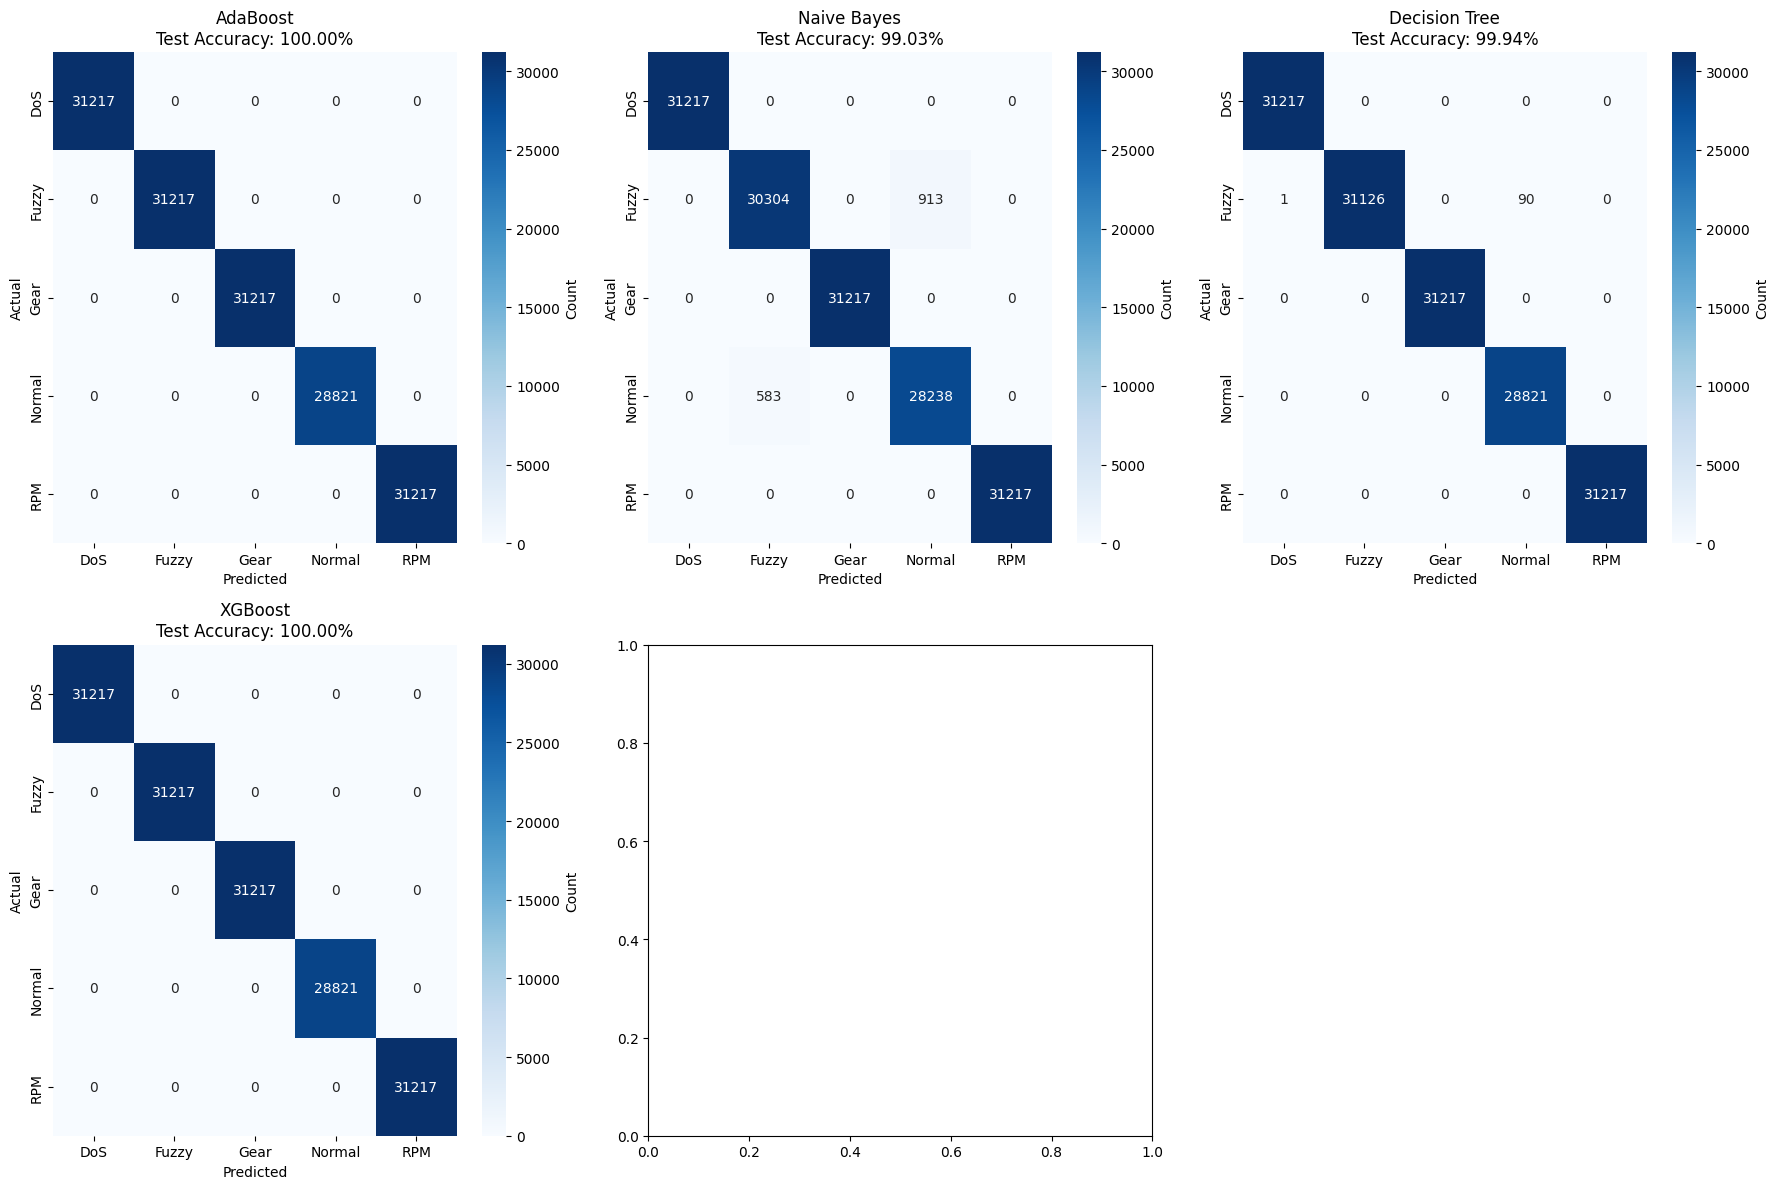

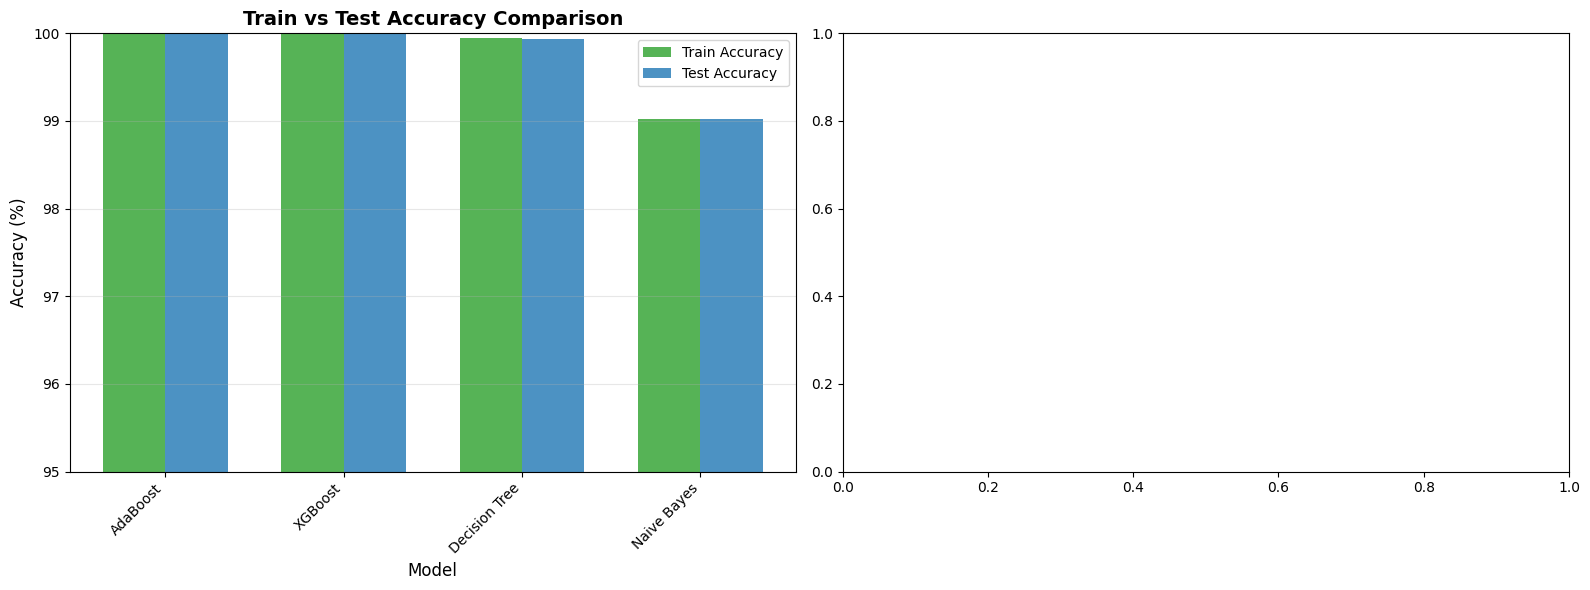

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

# 1. Load the full dataset
print("="*60)
print("MODEL COMPARISON: AdaBoost vs NBC vs CDT vs XGBoost")
print("="*60)

df = pd.read_csv('final_train_ready_scrubbed.csv')
X = df.drop(columns=['Label_Encoded', 'Label'])
y = df['Label_Encoded']

# 2. Split data: 80% Train / 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining Set: {len(X_train)} samples")
print(f"Test Set: {len(X_test)} samples\n")

# 3. Define all models
models = {
    'AdaBoost': AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=grid_search.best_params_['estimator__max_depth']),
        n_estimators=grid_search.best_params_['n_estimators'],
        learning_rate=grid_search.best_params_['learning_rate'],
        random_state=42
    ),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=6, random_state=42, eval_metric='mlogloss')
}

# 4. Train and evaluate all models
results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print(f"{'='*60}")
    
    # Train
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predict on both train and test sets
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics for both sets
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    cm = confusion_matrix(y_test, y_pred_test)
    report = classification_report(y_test, y_pred_test, target_names=encoder.classes_, output_dict=True)
    
    # Store results
    results[name] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_time': train_time,
        'confusion_matrix': cm,
        'report': report,
        'predictions': y_pred_test
    }
    
    print(f"Training Time: {train_time:.2f} seconds")
    print(f"Train Accuracy: {train_accuracy*100:.2f}%")
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"Difference (Train - Test): {(train_accuracy - test_accuracy)*100:.2f}%")

# 5. Create comparison summary
print(f"\n{'='*60}")
print("SUMMARY COMPARISON TABLE")
print(f"{'='*60}\n")

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train Acc (%)': [results[m]['train_accuracy']*100 for m in results.keys()],
    'Test Acc (%)': [results[m]['test_accuracy']*100 for m in results.keys()],
    'Difference (%)': [(results[m]['train_accuracy'] - results[m]['test_accuracy'])*100 for m in results.keys()],
    'Training Time (s)': [results[m]['train_time'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('Test Acc (%)', ascending=False)
print(comparison_df.to_string(index=False))

# Check for overfitting
print(f"\n{'='*60}")
print("OVERFITTING ANALYSIS")
print(f"{'='*60}")
for idx, row in comparison_df.iterrows():
    diff = row['Difference (%)']
    if diff > 5:
        print(f"{row['Model']:15} → Significant overfitting detected! (Δ = {diff:.2f}%)")
    elif diff > 2:
        print(f"{row['Model']:15} → Mild overfitting detected (Δ = {diff:.2f}%)")
    elif diff > -1:
        print(f"{row['Model']:15} → Good generalization (Δ = {diff:.2f}%)")
    else:
        print(f"{row['Model']:15} → Unusual: Test > Train (Δ = {diff:.2f}%)")

# 6. Detailed reports for each model
for name in results.keys():
    print(f"\n{'='*60}")
    print(f"{name.upper()} - DETAILED CLASSIFICATION REPORT")
    print(f"{'='*60}")
    print(classification_report(y_test, results[name]['predictions'], target_names=encoder.classes_))

# 7. Visualize confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues', 
                xticklabels=encoder.classes_, yticklabels=encoder.classes_,
                ax=axes[idx], cbar_kws={'label': 'Count'})
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_title(f"{name}\nTest Accuracy: {result['test_accuracy']*100:.2f}%")

axes[5].axis('off')

plt.tight_layout()
plt.show()

# 8. Bar chart comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
x_pos = np.arange(len(comparison_df))
width = 0.35

ax1.bar(x_pos - width/2, comparison_df['Train Acc (%)'], width, label='Train Accuracy', color='#2ca02c', alpha=0.8)
ax1.bar(x_pos + width/2, comparison_df['Test Acc (%)'], width, label='Test Accuracy', color='#1f77b4', alpha=0.8)
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Train vs Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax1.set_ylim(95, 100)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)



plt.tight_layout()
plt.show()

